In [1]:
import hashlib
import numpy as np
import statistics
import math
import collections
from zlib import crc32
import random
import operator
import scipy.stats as stats
from Crypto.Util import number
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from sympy import Symbol, solve, log
from scipy.optimize import fsolve
import scipy
import hashlib
import array

In [2]:
#helper function, verify if the input num is power of 2
def expo_of_two(num):
    result = num & (num-1)
    return result == 0


In [3]:
class CSSS_CountSketch():
    def __init__(self, d, t):
        # original count sketch t = O(1/epsilon) and d = O(log(1/delta)) 
        # think delta as U^{-c} d = O(logU)
        # d represent number of rows and t represent number of columns
        
        self.total_input = 0
        self.columns = t
        
        self.rows = d
        self.prime = number.getPrime(32)
        
        self.table_positive = np.zeros( (self.rows, self.columns) )
        self.table_negative = np.zeros( (self.rows, self.columns) )
        
        # generate 4-wise independent hash functions
        self.a = []
        self.b = []
        self.c = []
        self.d = []
        for i in range(d):
            aj, bj = np.random.randint(self.prime - 1, size=2) #randomly select one number from 0 to self.prime -1
            cj, dj = np.random.randint(self.prime - 1, size=2)
            assert aj != bj and cj!=dj
            self.a.append(aj+1)
            self.b.append(bj+1)
            self.c.append(cj+1)
            self.d.append(dj+1)
    def routine_a(self):
        for i in range(self.rows):
            for j in range(self.columns):
                self.table_positive[i][j] = np.random.binomial(self.table_positive[i][j], 1/2)
                self.table_negative[i][j] = np.random.binomial(self.table_negative[i][j], 1/2)

    def add(self, item, weight):
        self.update(item, weight)
        
    def update(self, item, weight=1):
        try:
            item = int(item)
        except:
            print("need integer for item value")
        
        self.total_input += weight

        for j in range(self.rows):
            hj = ( (self.a[j] * item + self.b[j]) % self.prime) % self.columns
            gj = 2 * (( (self.c[j] * item + self.d[j]) % self.prime) % 2) - 1
            updated_weight = weight * gj
            if updated_weight > 0:
                self.table_positive[j][hj] += updated_weight
            else:
                #updated_weight<0
                self.table_negative[j][hj] += abs(updated_weight)

    def query(self, item):
        try:
            item = int(item)
        except:
            print("need integer for item value")
        ans = []
        for j in range(self.rows):
            hj = int( ( (self.a[j] * item + self.b[j]) % self.prime) % self.columns )
            gj = 2 * (( (self.c[j] * item + self.d[j]) % self.prime) % 2) - 1
            assert( gj == -1 or gj == 1)
            ans.append ( gj * (self.table_positive[j][hj] - self.table_negative[j][hj] ))

        return statistics.median(ans)

    def inputsize(self):
        return self.total_input

    def countertable(self):
        return self.table

In [4]:
class CSSS_sketch():
    def __init__(self, epsilon=0.01, universe=2**16, k=100, alpha=2):
        assert k>=1
        assert 0<epsilon<1
        self.alpha = alpha
        self.epsilon = epsilon
        self.universe = universe
        
        self.T = math.ceil(4/(epsilon**2) + math.log2(universe))
        self.S = math.ceil( alpha*alpha/(epsilon*epsilon) * self.T*self.T* math.log2(universe) )
        self.d = math.ceil(math.log2(universe))
        self.multiple = math.ceil(math.log(self.S)) # used to perform binomial sampling
        
        self.k = math.ceil(k) * 6
        self.count_sketch = CSSS_CountSketch( self.d, self.k) # d x 6k 
        self.r = 1
        self.p = 0
        self.time = 0 #time <= |m|
    def update(self, item, weight=1):
        self.time += 1
        factor = (self.time -1) /self.multiple
        if (self.time -1)%self.multiple == 0 and expo_of_two(int(factor)) :
            self.count_sketch.routine_a()
            self.p+=1
        rand = random.random()
        if rand < 2**(-1*self.p):
            #sampled
            self.count_sketch.update(item, weight)
    def query(self, item):
        ans = self.count_sketch.query(item)
        return ans* (2**(self.p))
    def space(self):
        return math.floor( self.d*self.k*math.log2(self.alpha* math.log2(self.universe) / self.epsilon) )

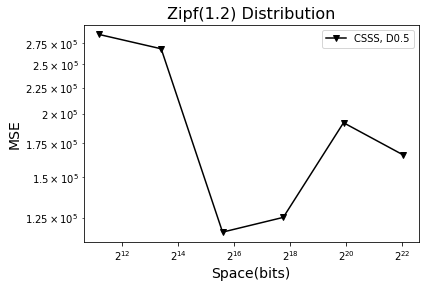

In [9]:

    csss_avg = {} #Mean Square Error 
    total_spaces = {}
    
    markers = {0.25:['bo-'], 0.5:['kv-'], 0.9:['rP-']}
    epsilons = [2**(-1),2**(-2),2**(-3),2**(-4),2**(-5), 2**(-6) ]
    runs = 5
    universe = 2**16
    size = 100000
    R = size # assume we can capture R without any error
    a = 1.2 #skewness
    rates = [0.5] #D = 0.5I
    alphas = [2]# 1 - 1/2 = 0.5
    
    for i in range(len(rates)):
        rate = rates[i]
        alpha = alphas[i]

        csss_avg_errors = []
        
        total_space = []
        
        for epsilon in epsilons:
            
            sum_csss_avg_error = 0
            k = 1.0/(epsilon**2)
            
            first_run = True
            
            for run in range(runs):

                CSSS = CSSS_sketch(epsilon, universe, k, alpha)

                if first_run:
                    first_run = False
                    total_space.append(CSSS.space())

                range_x = np.arange(1,universe)
                weights = range_x ** (-a)
                weights /= weights.sum()
                bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))
                
                insertions = bounded_zipf.rvs(size=size)   
                deletions = random.sample(list(insertions), int(rate*size))

                true_result = {}
                for i in insertions:
                    CSSS.update(str(i), 1)
                    true_result[str(i)] = true_result.get(str(i), 0) + 1

                for i in deletions:
                    CSSS.update(str(i), -1)
                    true_result[str(i)] -= 1
                
                csss_avg_error = 0

                for item in true_result.keys():
                    csss_estimate = CSSS.query(item)
                    csss_error = abs(true_result.get(item,0) - csss_estimate)
                    
                    csss_avg_error += csss_error**2

                u = len(true_result.keys())
                csss_avg_error = 1.0*csss_avg_error / u
                
                sum_csss_avg_error += csss_avg_error

            csss_avg_errors.append(sum_csss_avg_error/ runs)
        
        csss_avg[rate] = csss_avg_errors
        total_spaces[rate] = total_space

    
    plt.figure()
    plt.title("Zipf("+str(a)+") Distribution", fontsize=16) 
    plt.xlabel('Space(bits)', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.yscale('log', basey=10)
    plt.xscale('log', basex=2)
    for i in range(len(rates)):
        plt.plot(total_spaces[rates[i]], csss_avg[rates[i]], markers[rates[i]][0],label='CSSS, '+"D"+str(rates[i]))

    plt.legend(prop={'size': 10})

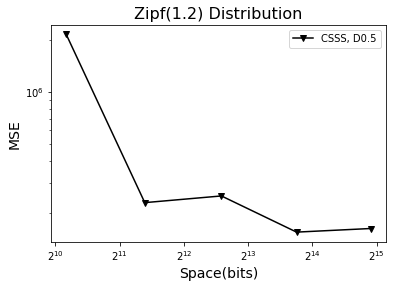

In [6]:

    csss_avg = {} #Mean Square Error 
    total_spaces = {}
    
    markers = {0.25:['bo-'], 0.5:['kv-'], 0.9:['rP-']}
    epsilons = [2**(-1),2**(-2),2**(-3),2**(-4),2**(-5) ]
    runs = 5
    universe = 2**16
    size = 100000
    R = size # assume we can capture R without any error
    a = 1.2 #skewness
    rates = [0.5] #D = 0.5I
    alphas = [2]# 1 - 1/2 = 0.5
    
    for i in range(len(rates)):
        rate = rates[i]
        alpha = alphas[i]

        csss_avg_errors = []
        
        total_space = []
        
        for epsilon in epsilons:
            
            sum_csss_avg_error = 0
            k = 1.0/(epsilon)
            
            first_run = True
            
            for run in range(runs):

                CSSS = CSSS_sketch(epsilon, universe, k, alpha)

                if first_run:
                    first_run = False
                    total_space.append(CSSS.space())

                range_x = np.arange(1,universe)
                weights = range_x ** (-a)
                weights /= weights.sum()
                bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(range_x, weights))
                
                insertions = bounded_zipf.rvs(size=size)   
                deletions = random.sample(list(insertions), int(rate*size))

                true_result = {}
                for i in insertions:
                    CSSS.update(str(i), 1)
                    true_result[str(i)] = true_result.get(str(i), 0) + 1

                for i in deletions:
                    CSSS.update(str(i), -1)
                    true_result[str(i)] -= 1
                
                csss_avg_error = 0

                for item in true_result.keys():
                    csss_estimate = CSSS.query(item)
                    csss_error = abs(true_result.get(item,0) - csss_estimate)
                    
                    csss_avg_error += csss_error**2

                u = len(true_result.keys())
                csss_avg_error = 1.0*csss_avg_error / u
                
                sum_csss_avg_error += csss_avg_error

            csss_avg_errors.append(sum_csss_avg_error/ runs)
        
        csss_avg[rate] = csss_avg_errors
        total_spaces[rate] = total_space

    
    plt.figure()
    plt.title("Zipf("+str(a)+") Distribution", fontsize=16) 
    plt.xlabel('Space(bits)', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.yscale('log', basey=10)
    plt.xscale('log', basex=2)
    for i in range(len(rates)):
        plt.plot(total_spaces[rates[i]], csss_avg[rates[i]], markers[rates[i]][0],label='CSSS, '+"D"+str(rates[i]))

    plt.legend(prop={'size': 10})